In [ ]:
!pip install -q diffusers transformers accelerate peft safetensors
!pip install -q torchmetrics[image] lpips clean-fid
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 25.4 MB/s eta 0:00:00


In [ ]:
import os

In [ ]:
import json
import gc
import torch
import torch.nn.functional as F
from PIL import Image
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler
from transformers import BlipProcessor, BlipForConditionalGeneration
from diffusers import StableDiffusionInpaintPipeline, DPMSolverMultistepScheduler
from peft import LoraConfig, get_peft_model, set_peft_model_state_dict
from safetensors.torch import load_file

In [ ]:
ZIP_TRAIN_PATH = "/content/dl_train.zip"
ZIP_TEST_PATH  = "/content/dl_test.zip"

def unzip_if_needed(zip_path, extract_to_root="/content"):
    folder_name = os.path.basename(zip_path).replace(".zip", "")
    target_dir = os.path.join(extract_to_root, folder_name)

    if os.path.exists(target_dir) and len(os.listdir(target_dir)) > 0:
        print(f"{folder_name} đã tồn tại, bỏ qua.")
        return

    if not os.path.exists(zip_path):
        raise FileNotFoundError(f"Không tìm thấy {zip_path}")

    print(f"Giải nén {os.path.basename(zip_path)}...")
    os.system(f"unzip -q -o {zip_path} -d {extract_to_root}")
    print(f"Xong: {target_dir}")

In [ ]:
unzip_if_needed(ZIP_TRAIN_PATH)

In [ ]:
unzip_if_needed(ZIP_TEST_PATH)

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

CHECKPOINT_DIR = "/content/drive/MyDrive/my_inpainting_checkpoints_full"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

Mounted at /content/drive


In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline
from peft import LoraConfig, get_peft_model

# 1. Load Base Model (SD 1.5 Inpainting)
model_id = "runwayml/stable-diffusion-inpainting"
device = "cuda"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None
).to(device)

pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.unet.requires_grad_(False)

# 2. Cấu hình LoRA (Fine-tune)
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.05,
    bias="none",
)

pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
You have disable

trainable params: 3,188,736 || all params: 862,724,100 || trainable%: 0.3696


In [ ]:
DATA_TRAIN_LOCAL = "/content/dl_train"

In [ ]:
DATA_TEST_LOCAL = "/content/dl_test"

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class InpaintingDataset(Dataset):
    def __init__(self, root, size=512):
        self.masked_dir = os.path.join(root, "masked_images")
        self.mask_dir = os.path.join(root, "masks")
        self.gt_dir = os.path.join(root, "ground_truth")
        self.size = size

        self.files = sorted([f for f in os.listdir(self.masked_dir) if f.endswith(('.png', '.jpg'))])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        clean_name = fname.replace("masked_", "")

        masked_path = os.path.join(self.masked_dir, fname)

        mask_path = os.path.join(self.mask_dir, f"mask_{clean_name}")
        if not os.path.exists(mask_path):
            mask_path = os.path.join(self.mask_dir, clean_name)

        gt_path = os.path.join(self.gt_dir, f"gt_{clean_name}")

        if not os.path.exists(gt_path):
            gt_path = os.path.join(self.gt_dir, clean_name)

        try:
            masked_img = Image.open(masked_path).convert("RGB").resize((self.size, self.size))
            mask = Image.open(mask_path).convert("L").resize((self.size, self.size))
            gt_img = Image.open(gt_path).convert("RGB").resize((self.size, self.size))
        except FileNotFoundError as e:

            print(f"LỖI KHÔNG TÌM THẤY FILE: {e.filename}")
            return self.__getitem__(0)

        prompt = "high quality, realistic"

        t_img = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
        t_mask = transforms.ToTensor()

        return {
            "masked": t_img(masked_img),
            "mask": t_mask(mask),
            "gt": t_img(gt_img),
            "prompt": prompt
        }

In [ ]:
# --- KHỞI TẠO LẠI DATASET ---
train_ds = InpaintingDataset(DATA_TRAIN_LOCAL)
train_dataloader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

print(f"Đã load dataset: {len(train_ds)} ảnh Train.")

In [ ]:
test_ds = InpaintingDataset(DATA_TEST_LOCAL)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=2)

In [ ]:
def save_full_checkpoint(epoch, unet, optimizer, scaler, root_dir):
    save_dir = os.path.join(root_dir, f"checkpoint-epoch-{epoch}")
    os.makedirs(save_dir, exist_ok=True)

    print(f"Đang lưu Full Checkpoint tại Epoch {epoch}...")

    unet.save_pretrained(save_dir)

    train_state = {
        "epoch": epoch,
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict()
    }
    torch.save(train_state, os.path.join(save_dir, "train_state.pt"))
    print(f"Đã lưu xong Epoch {epoch}!")

def load_latest_checkpoint(unet, optimizer, scaler, root_dir):
    if not os.path.exists(root_dir): return 0
    all_dirs = [d for d in os.listdir(root_dir) if d.startswith("checkpoint-epoch-")]

    if not all_dirs:
        print("Không tìm thấy checkpoint cũ. Bắt đầu train mới.")
        return 0

    all_dirs.sort(key=lambda x: int(x.split("-")[-1]))
    latest_dir = all_dirs[-1]
    load_path = os.path.join(root_dir, latest_dir)

    print(f"Phát hiện checkpoint cũ: {latest_dir}. Đang khôi phục...")

    from peft import PeftModel
    try:
        unet.load_adapter(load_path, "default")
    except Exception as e:
        print(f"Model base có thể chưa khớp adapter, nhưng sẽ được nạp đè: {e}")

    state_path = os.path.join(load_path, "train_state.pt")
    if os.path.exists(state_path):
        state = torch.load(state_path)
        optimizer.load_state_dict(state["optimizer_state"])
        scaler.load_state_dict(state["scaler_state"])
        start_epoch = state["epoch"] + 1
        print(f"Đã khôi phục thành công! Tiếp tục từ Epoch {start_epoch}")
        return start_epoch
    else:
        print("Checkpoint lỗi (thiếu file state). Train lại epoch này.")
        return int(latest_dir.split("-")[-1])

In [ ]:
# --- CONFIG ---
TRAIN_IMG_DIR = "/content/dl_train"
CAPTION_FILE = "/content/data/train_captions.json"
OUTPUT_DIR = "/content/drive/MyDrive/StableDiffusion_LoRA_Inpainting"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LR = 1e-4
NUM_EPOCHS = 5
LORA_RANK = 64
BASE_MODEL = "runwayml/stable-diffusion-inpainting"
DEVICE = "cuda"

# --- HELPER FUNCTIONS ---
def save_checkpoint(epoch, unet, optimizer, scaler, output_dir):
    save_path = os.path.join(output_dir, f"checkpoint-epoch-{epoch}")
    os.makedirs(save_path, exist_ok=True)

    unet.save_pretrained(save_path)

    state = {
        "epoch": epoch,
        "optimizer": optimizer.state_dict(),
        "scaler": scaler.state_dict()
    }
    torch.save(state, os.path.join(save_path, "train_state.pt"))
    print(f"Saved checkpoint: {save_path}")

def resume_from_checkpoint(unet, optimizer, scaler, output_dir):
    if not os.path.exists(output_dir): return 0

    checkpoints = [d for d in os.listdir(output_dir) if d.startswith("checkpoint-epoch-")]
    if not checkpoints: return 0

    try:
        checkpoints.sort(key=lambda x: int(x.split("-")[-1]))
    except ValueError: return 0

    latest_ckpt = checkpoints[-1]
    load_path = os.path.join(output_dir, latest_ckpt)
    print(f"Resuming from: {latest_ckpt}")

    # Load Weights
    if os.path.exists(os.path.join(load_path, "adapter_model.safetensors")):
        weights = load_file(os.path.join(load_path, "adapter_model.safetensors"))
        set_peft_model_state_dict(unet, weights)

    # Load State
    state_file = os.path.join(load_path, "train_state.pt")
    if os.path.exists(state_file):
        state = torch.load(state_file)
        optimizer.load_state_dict(state["optimizer"])
        scaler.load_state_dict(state["scaler"])
        return state["epoch"] + 1

    return int(latest_ckpt.split("-")[-1])

# --- PART 1: AUTO CAPTIONING (BLIP) ---
def generate_captions(image_dir, json_path):
    if os.path.exists(json_path):
        print(f"Caption file exists: {json_path}")
        return

    print("Generating captions for 5000 images...")

    processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(DEVICE)
    model.eval()

    captions_dict = {}
    valid_exts = {".png"}
    image_files = [f for f in os.listdir(image_dir) if os.path.splitext(f)[1].lower() in valid_exts]

    batch_size = 8
    for i in tqdm(range(0, len(image_files), batch_size), desc="Captioning"):
        batch_files = image_files[i : i + batch_size]
        batch_images = []

        for f in batch_files:
            img = Image.open(os.path.join(image_dir, f)).convert("RGB")
            batch_images.append(img)

        inputs = processor(images=batch_images, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model.generate(**inputs, max_new_tokens=50)

        captions = processor.batch_decode(out, skip_special_tokens=True)

        for filename, cap in zip(batch_files, captions):
            captions_dict[filename] = cap

    with open(json_path, "w") as f:
        json.dump(captions_dict, f, indent=4)

    del model
    del processor
    del inputs
    torch.cuda.empty_cache()
    gc.collect()
    print("VRAM cleared.")

# Run Captioning
generate_captions(TRAIN_IMG_DIR, CAPTION_FILE)

# --- PART 2: STABLE DIFFUSION SETUP ---
print(f"Loading SD Model: {BASE_MODEL}")
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    BASE_MODEL, torch_dtype=torch.float16, use_safetensors=False
).to(DEVICE)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.unet.requires_grad_(False)

lora_conf = LoraConfig(
    r=LORA_RANK, lora_alpha=LORA_RANK,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.05, bias="none"
)
pipe.unet = get_peft_model(pipe.unet, lora_conf)
pipe.unet.print_trainable_parameters()

optimizer = torch.optim.AdamW(pipe.unet.parameters(), lr=LR)
scaler = GradScaler('cuda')

# Resume
start_epoch = resume_from_checkpoint(pipe.unet, optimizer, scaler, OUTPUT_DIR)

# --- PART 3: TRAINING LOOP ---

print(f"Starting training from Epoch {start_epoch + 1}")
pipe.unet.train()

for epoch in range(start_epoch, NUM_EPOCHS):
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

    for batch in progress_bar:
        # Data Preparation
        gt = batch["gt"].to(DEVICE, dtype=torch.float16)
        masked = batch["masked"].to(DEVICE, dtype=torch.float16)
        mask = batch["mask"].to(DEVICE, dtype=torch.float16)

        with torch.no_grad():
            # VAE Encode
            latents = pipe.vae.encode(gt).latent_dist.sample() * pipe.vae.config.scaling_factor
            masked_latents = pipe.vae.encode(masked).latent_dist.sample() * pipe.vae.config.scaling_factor

            # Resize Mask (512 -> 64)
            mask_64 = F.interpolate(mask, size=(64, 64), mode="nearest")

            # Text Encode
            tokens = pipe.tokenizer(
                batch["prompt"],
                padding="max_length",
                truncation=True,
                max_length=pipe.tokenizer.model_max_length,
                return_tensors="pt"
            ).input_ids.to(DEVICE)
            encoder_hidden = pipe.text_encoder(tokens)[0]

        # Noise & Timesteps
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, pipe.scheduler.config.num_train_timesteps, (latents.shape[0],), device=DEVICE).long()
        noisy_latents = pipe.scheduler.add_noise(latents, noise, timesteps)

        # Model Input
        model_input = torch.cat([noisy_latents, mask_64, masked_latents], dim=1)

        # Prediction & Loss
        with autocast('cuda'):
            noise_pred = pipe.unet(model_input, timesteps, encoder_hidden).sample
            loss = F.mse_loss(noise_pred, noise)

        # Backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())

    # Save Checkpoint
    save_checkpoint(epoch + 1, pipe.unet, optimizer, scaler, OUTPUT_DIR)

print("Training Completed.")

##Test

🔍 Đang test trên các ID: [479, 28, 245, 311]
[1/5] Đang xử lý ID 479...


  0%|          | 0/50 [00:00<?, ?it/s]

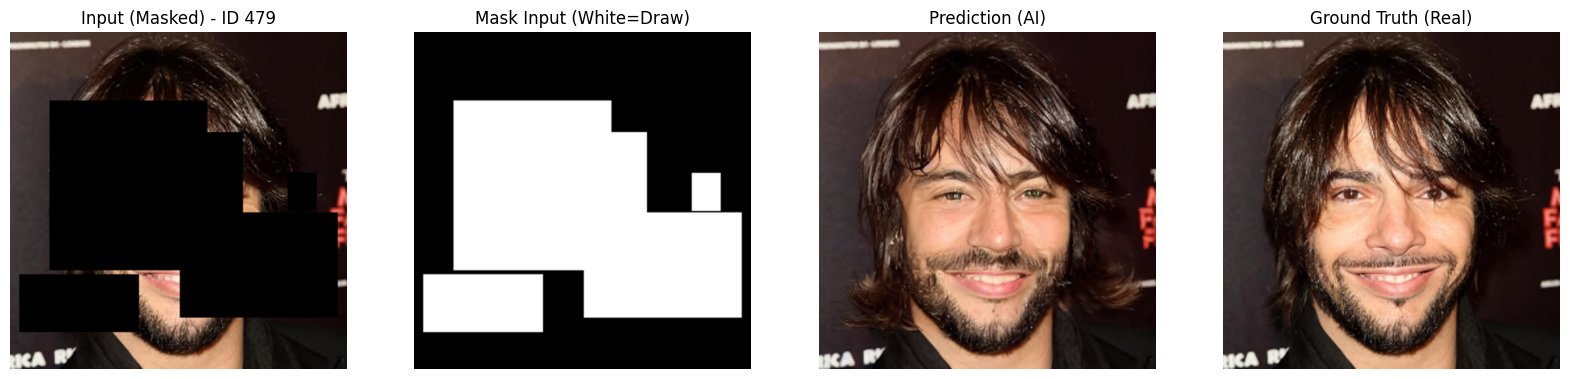

[2/5] Đang xử lý ID 28...


  0%|          | 0/50 [00:00<?, ?it/s]

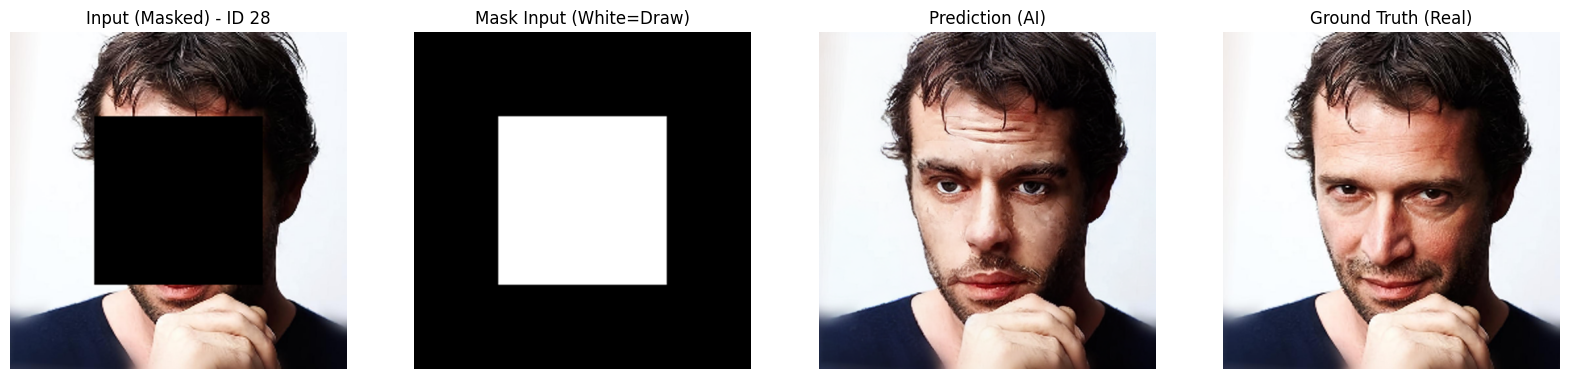

[3/5] Đang xử lý ID 245...


  0%|          | 0/50 [00:00<?, ?it/s]

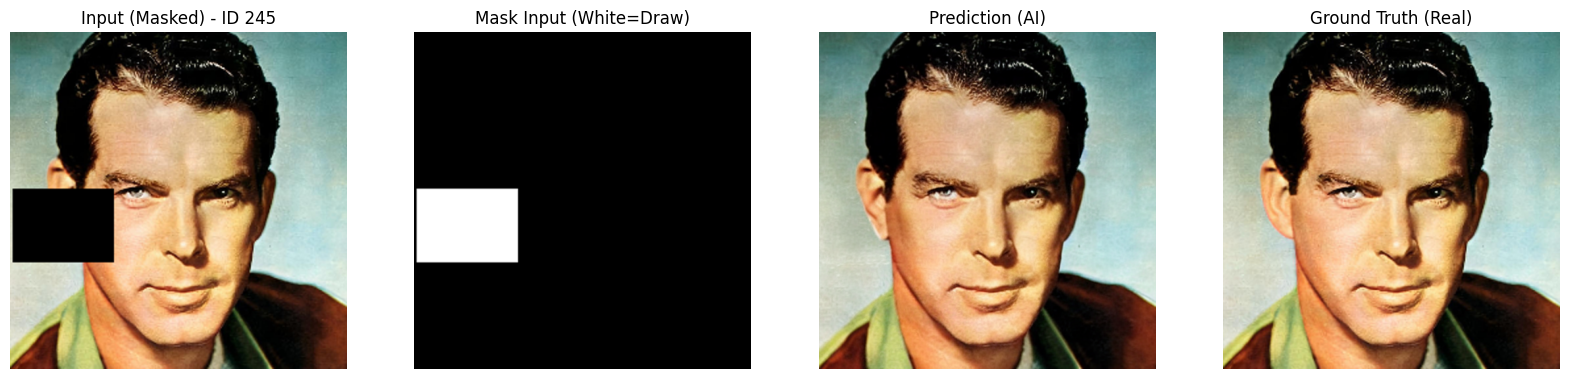

[4/5] Đang xử lý ID 311...


  0%|          | 0/50 [00:00<?, ?it/s]

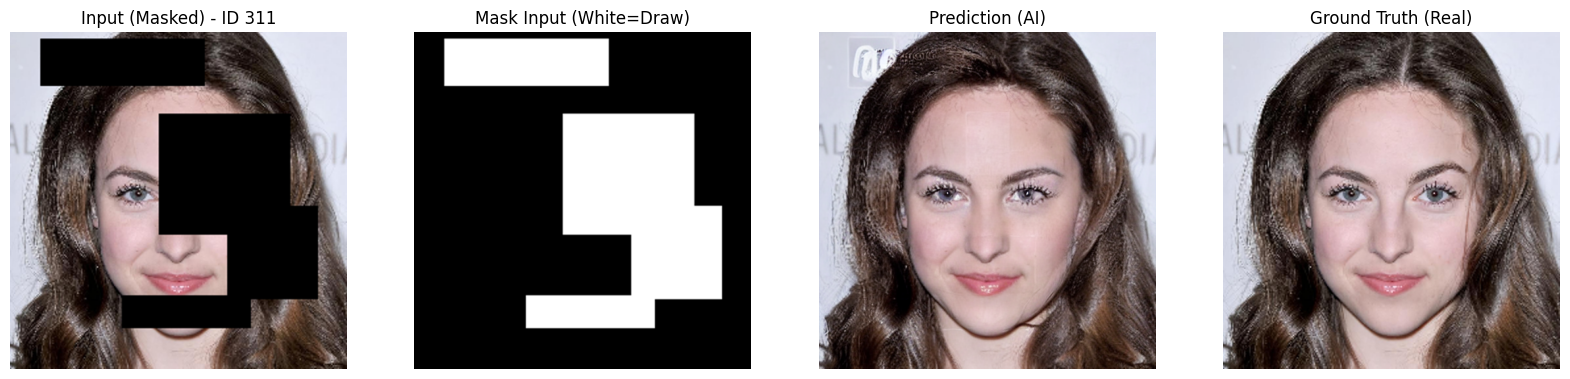

In [ ]:
import random
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch

local_dir = "/content/drive/MyDrive/dl_test"
num_samples = 5

masked_dir = f"{local_dir}/masked_images"
all_files = [f for f in os.listdir(masked_dir) if f.startswith("masked_") and f.endswith((".png", ".jpg"))]

all_ids = [f.replace("masked_", "").split(".")[0] for f in all_files]

if len(all_ids) < num_samples:
    print(f"Chỉ tìm thấy {len(all_ids)} ảnh, sẽ test hết.")
    sample_ids = all_ids
else:
    sample_ids = [479, 28, 245, 311]

print(f"🔍 Đang test trên các ID: {sample_ids}")

generator = torch.Generator("cuda").manual_seed(42)

for i, id_ in enumerate(sample_ids):
    try:
        img_path = f"{local_dir}/masked_images/masked_{id_}.png"
        mask_path = f"{local_dir}/masks/mask_{id_}.png"
        gt_path = f"{local_dir}/ground_truth/gt_{id_}.png"

        masked_image = Image.open(img_path).convert("RGB").resize((512, 512))
        mask_image = Image.open(mask_path).convert("L").resize((512, 512))
        gt_image = Image.open(gt_path).convert("RGB").resize((512, 512))

        mask_input = ImageOps.invert(mask_image)

        print(f"[{i+1}/{num_samples}] Đang xử lý ID {id_}...")
        result = pipe(
            prompt="",
            image=masked_image,
            mask_image=mask_input,
            num_inference_steps=50,
            guidance_scale=7.5,
            generator=generator
        ).images[0]

        fig, axs = plt.subplots(1, 4, figsize=(20, 5))

        axs[0].imshow(masked_image)
        axs[0].set_title(f"Input (Masked) - ID {id_}")
        axs[0].axis("off")

        axs[1].imshow(mask_input, cmap="gray")
        axs[1].set_title("Mask Input (White=Draw)")
        axs[1].axis("off")

        axs[2].imshow(result)
        axs[2].set_title("Prediction (AI)")
        axs[2].axis("off")

        axs[3].imshow(gt_image)
        axs[3].set_title("Ground Truth (Real)")
        axs[3].axis("off")

        plt.show()

    except Exception as e:
        print(f"Lỗi khi xử lý ID {id_}: {e}")

In [ ]:
!zip -r best_model.zip {CHECKPOINT_DIR}/best_model_final
print("Đã nén xong! Tải file 'best_model.zip' ở cột bên trái.")

In [ ]:
import gradio as gr
import torch
from peft import PeftModel
from PIL import Image, ImageOps
import os

if 'CHECKPOINT_DIR' not in globals():
    CHECKPOINT_DIR = "/content/drive/MyDrive/my_inpainting_checkpoints_full"

BEST_MODEL_PATH = os.path.join(CHECKPOINT_DIR, "best_model_final")

def load_model():
    if 'pipe' not in globals():
        return "Lỗi: Biến 'pipe' chưa khởi tạo. Hãy chạy cell load Pipeline ở trên trước."

    print(f"Đang load model từ: {BEST_MODEL_PATH}")

    if not os.path.exists(BEST_MODEL_PATH):
        return "Lỗi: Không tìm thấy thư mục 'best_model'. Hãy kiểm tra lại quá trình train!"

    try: pipe.unet.unload_lora()
    except: pass

    try:
        pipe.unet.load_adapter(BEST_MODEL_PATH, adapter_name="default")
        pipe.to("cuda")
        return "Model LoRA đã sẵn sàng!"
    except Exception as e:
        return f"❌ Lỗi load model: {e}"

status_msg = load_model()
print(status_msg)

def predict(input_dict, prompt_text):
    if input_dict is None:
        return None, None

    image = input_dict["background"].convert("RGB").resize((512, 512))

    if not input_dict["layers"]:
        return image, image

    draw_layer = input_dict["layers"][0].resize((512, 512))

    if draw_layer.mode == 'RGBA':
        mask = draw_layer.getchannel('A')
    else:
        mask = draw_layer.convert("L")

    if mask.getextrema() == (0, 0):
        if input_dict["background"].mode == 'RGBA':
            mask = input_dict["background"].getchannel('A')
        else:
            return image, image

    if not prompt_text.strip(): prompt_text = "high quality, realistic"
    print(f"Generating... '{prompt_text}'")

    with torch.no_grad():
        with torch.amp.autocast("cuda"):
            output = pipe(
                prompt=prompt_text,
                image=image,
                mask_image=mask,
                num_inference_steps=30,
                guidance_scale=7.5
            ).images[0]

    return image, output

css = "footer {visibility: hidden}"

with gr.Blocks(title="Inpainting Compare", css=css, theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🎨 Inpainting Demo (So sánh Trước & Sau)")
    gr.Markdown(f"**Status:** {status_msg}")

    with gr.Row():
        # CỘT TRÁI: INPUT
        with gr.Column(scale=1):
            input_img = gr.ImageEditor(
                label="B1: Upload & Vẽ Mask",
                type="pil",
                crop_size=(512, 512),
                brush=gr.Brush(colors=["#FFFFFF"], default_size=25),
                eraser=gr.Eraser(default_size=25),
                layers=False
            )
            prompt = gr.Textbox(label="B2: Nhập Prompt", value="high quality, realistic")
            btn = gr.Button("✨ CHẠY (GENERATE)", variant="primary", size="lg")

        with gr.Column(scale=1):
            gr.Markdown("### 🔍 So sánh kết quả")
            with gr.Row():
                img_original = gr.Image(label="Ảnh Gốc (Original)", interactive=False)
                img_result = gr.Image(label="Kết quả (Inpainted)", interactive=False)

    btn.click(
        fn=predict,
        inputs=[input_img, prompt],
        outputs=[img_original, img_result]
    )

# --- 4. CHẠY ---
print("🚀 Đang khởi động Gradio...")
demo.launch(share=True, debug=True)

🔄 Đang load model từ: /content/drive/MyDrive/my_inpainting_checkpoints_full/best_model_final
✅ Model LoRA đã sẵn sàng!


/tmp/ipython-input-3004076118.py:88: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(title="Inpainting Compare", css=css, theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-3004076118.py:88: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(title="Inpainting Compare", css=css, theme=gr.themes.Soft()) as demo:


🚀 Đang khởi động Gradio...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://46f321fcc20b6becc2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'handsome boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'handsome man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'handsome boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'handsome boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'handsome boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'boy'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'woman'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'woman'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'man'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'woman'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'woman'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]

Generating... 'high quality, realistic'


  0%|          | 0/30 [00:00<?, ?it/s]